# New Section

In [ ]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

In [ ]:
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Text preprocessing function

str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

In [ ]:
# Read dataset & Preprocess text
df_train = pd.read_csv('train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('test.txt', names=['Text', 'Emotion'], sep=';')

X_train = df_train['Text'].apply(clean)
y_train = df_train['Emotion']

X_test = df_test['Text'].apply(clean)
y_test = df_test['Emotion']

X_val = df_val['Text'].apply(clean)
y_val = df_val['Emotion']

# New Section

In [ ]:
# Tokenize words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))


sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(sequences_train, maxlen=256, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=256, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=256, truncating='pre')

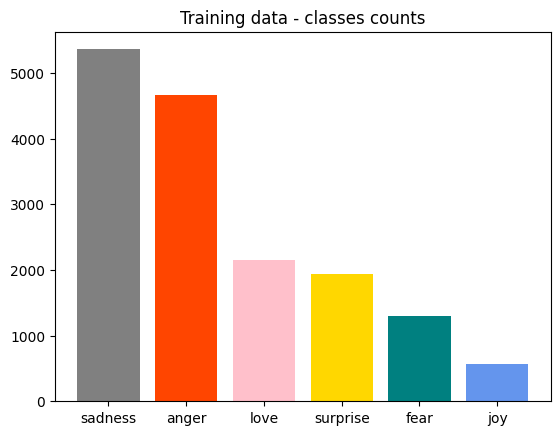

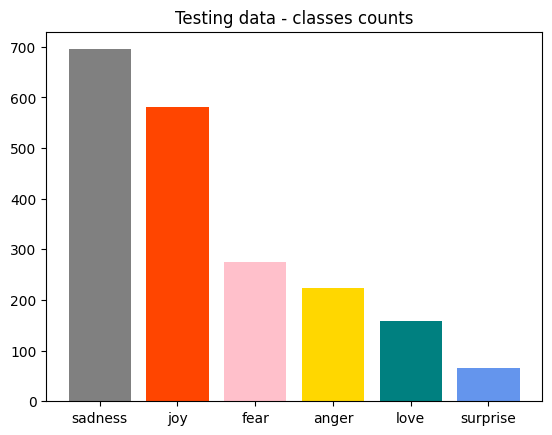

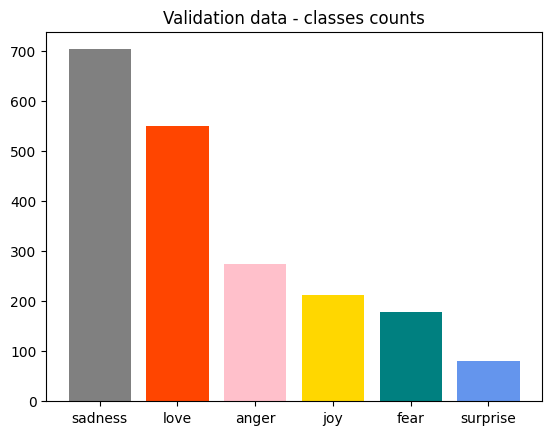

In [ ]:
# Visualize classes counts
colors = np.array(["gray", 'orangered', 'pink', 'gold', 'teal', 'cornflowerblue'])

plt.bar(y_train.unique(), height=y_train.value_counts(), color=colors)
plt.title("Training data - classes counts")
plt.show()

plt.bar(y_test.unique(), height=y_test.value_counts(), color=colors)
plt.title("Testing data - classes counts")
plt.show()

plt.bar(y_val.unique(), height=y_val.value_counts(), color=colors)
plt.title("Validation data - classes counts")
plt.show()

In [ ]:
# Encode labels

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 14452


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2024-07-06 11:53:25--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-07-06 11:53:25--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-07-06 11:53:25--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
# Read GloVE embeddings

path_to_glove_file = 'glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200
hits = 0
misses = 0
embeddings_index = {}

# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))


# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 13370 words (1081 misses)


In [ ]:
# Build neural network architecture

adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 200)          2890400   
                                                                 
 bidirectional (Bidirection  (None, 256, 512)          935936    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256, 256)          656384    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 6)                 1542      
                                                        

In [ ]:
callback = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True,
)

In [ ]:
# Fit model
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    batch_size=256,
                    epochs=10,
                    callbacks=[callback]
                   )

Epoch 1/10
63/63 [==============================] - 495s 8s/step - loss: 1.4708 - accuracy: 0.4339 - val_loss: 1.1700 - val_accuracy: 0.5625
Epoch 2/10
63/63 [==============================] - 501s 8s/step - loss: 1.0275 - accuracy: 0.6181 - val_loss: 0.7087 - val_accuracy: 0.7440
Epoch 3/10
63/63 [==============================] - 480s 8s/step - loss: 0.5848 - accuracy: 0.7968 - val_loss: 0.3815 - val_accuracy: 0.8730
Epoch 4/10
63/63 [==============================] - 491s 8s/step - loss: 0.2530 - accuracy: 0.9056 - val_loss: 0.2273 - val_accuracy: 0.9085
Epoch 5/10
63/63 [==============================] - 485s 8s/step - loss: 0.1656 - accuracy: 0.9305 - val_loss: 0.1736 - val_accuracy: 0.9220
Epoch 6/10
63/63 [==============================] - 489s 8s/step - loss: 0.1284 - accuracy: 0.9391 - val_loss: 0.1655 - val_accuracy: 0.9255
Epoch 7/10
63/63 [==============================] - 501s 8s/step - loss: 0.1081 - accuracy: 0.9484 - val_loss: 0.1973 - val_accuracy: 0.9235
Epoch 8/10
63

In [ ]:
model.evaluate(X_val, y_val, verbose=1)

63/63 [==============================] - 26s 413ms/step - loss: 0.1271 - accuracy: 0.9425


[0.12711350619792938, 0.9424999952316284]

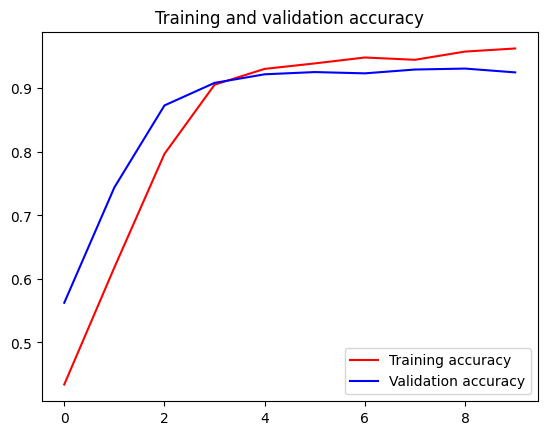

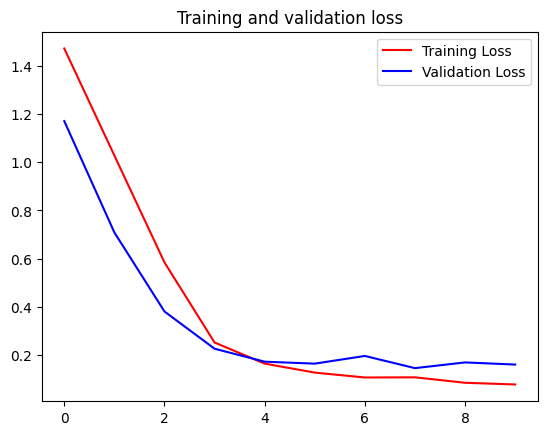

In [ ]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Classify custom sample

sentences = [
            "Nowadays people only think about lying and cheating",
            "Your point on this certain matter made me outrageous, how can you say so? This is insane.",
            "I can't do it, I'm not ready to lose anything, just leave me alone",
            "Merlin's beard harry, you can cast the Patronus charm! I'm amazed!"
            ]
for sentence in sentences:
    print(sentence)
    sentence = clean(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=256, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

Nowadays people only think about lying and cheating
1/1 [==============================] - 0s 197ms/step
anger : 0.4273497760295868


Your point on this certain matter made me outrageous, how can you say so? This is insane.
1/1 [==============================] - 0s 202ms/step
anger : 0.8379302620887756


I can't do it, I'm not ready to lose anything, just leave me alone
1/1 [==============================] - 0s 193ms/step
sadness : 0.3340452015399933


Merlin's beard harry, you can cast the Patronus charm! I'm amazed!
1/1 [==============================] - 0s 181ms/step
surprise : 0.8700460195541382




In [ ]:
# Calculate accuracy, precision, recall, and F1 score
from sklearn.metrics import classification_report, accuracy_score

# Predict the labels for the validation set
y_pred_val = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val, axis=1)
y_true_val_classes = np.argmax(y_val, axis=1)

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_true_val_classes, y_pred_val_classes)
report = classification_report(y_true_val_classes, y_pred_val_classes, target_names=le.classes_)

print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", report)

63/63 [==============================] - 27s 421ms/step
Accuracy: 0.9425

Classification Report:
               precision    recall  f1-score   support

       anger       0.94      0.94      0.94       275
        fear       0.87      0.92      0.90       212
         joy       0.95      0.97      0.96       704
        love       0.93      0.85      0.89       178
     sadness       0.97      0.97      0.97       550
    surprise       0.98      0.77      0.86        81

    accuracy                           0.94      2000
   macro avg       0.94      0.90      0.92      2000
weighted avg       0.94      0.94      0.94      2000



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pickle
# Save model
model.save('/content/drive/MyDrive/LSTM/Emotion Recognition.h5')

# Save tokenizer and label encoder
with open('/content/drive/MyDrive/LSTM/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/LSTM/label_encoder.pickle', 'wb') as handle:
    pickle.dump(le, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save training history
with open('/content/drive/MyDrive/LSTM/training_history.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
